In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df=pd.read_csv("Data/NFLX.csv",parse_dates=["Date"],index_col="Date")


In [3]:

df2 = df.iloc[-90:]
df_1 = pd.date_range(start=df2.index[-1] + pd.Timedelta(days=1), periods=5)
df_3 = pd.date_range(start=df2.index[-1] + pd.Timedelta(days=1), end=df_1[-1])
df2_sliced = df2.tail(5)

next_df = pd.DataFrame({
    "Open": df2_sliced["Open"].values,
    "High": df2_sliced["High"].values,
    "Low": df2_sliced["Low"].values,
    "Close": df2_sliced["Close"].values,
    "Adj Close": df2_sliced["Adj Close"].values,
    "Volume": df2_sliced["Volume"].values
}, index=df_1)

In [4]:
df=pd.concat([df,next_df])
df.columns=df.columns.str.lower()

In [5]:
df["target"]=df["close"].shift(-1).ffill()
filt=df.columns.isin(["adj close","target","low"])
predictors=df.columns[~filt]
X=df[predictors]
y=df["target"]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error
R=LinearRegression()
def backtest(data,model,predictors,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["target"]
        X_test=test[predictors]
        y_test=test["target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)


In [7]:
Combined=backtest(df,R,predictors)

In [8]:
Combined
acc=r2_score(Combined["Actual"],Combined["Predicted"])

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()

vif=pd.DataFrame(dict({"vif":[variance_inflation_factor(x.values,i)for i in range(x.shape[1])],"features":x.columns}))

In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     3048.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          5.15e-212
Time:                        16:45:58   Log-Likelihood:                -929.36
No. Observations:                 257   AIC:                             1869.
Df Residuals:                     252   BIC:                             1886.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1674      3.794      1.626      0.105      -1.305      13.639
open          -0.0084      0.119     -0.071      0.944      -0.242       0.225
high           0.0102      0.203      0.050      0.960      -0.390       0.410
close          0.9826      0.140      7.023      0.000       0.707       1.258
volume     -3.292e-08    1.3e-07     -0.254      0.800   -2.88e-07    2.23e-07
==============================================================================
Omnibus:                       17.298   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.987
Skew:                           0.205   Prob(JB):                     1.70e-10
Kurtosis:                       5.008   Cond. No.                     6.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

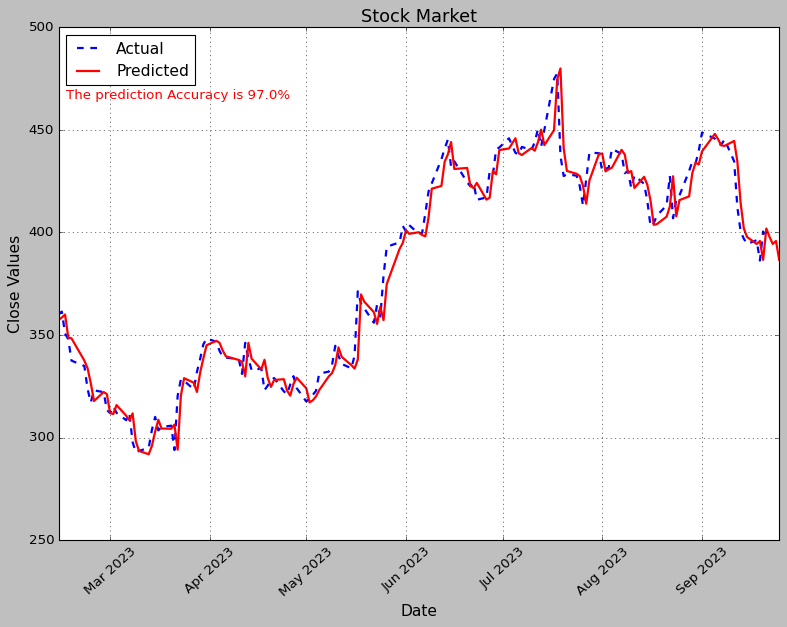

In [15]:
import matplotlib.pyplot as plt
from datetime import datetime
current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
U=Combined.loc[:f"{DATE}"]

plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(U.index,U["Actual"],"b--",label="Actual",linewidth=2)
plt.plot(Combined.index,Combined["Predicted"],"r-",label="Predicted",linewidth=2)
plt.legend(loc="upper left",fontsize=14)
plt.xticks(rotation=42)
# Annotating a point
plt.annotate(f"The prediction Accuracy is {round(acc,2)*100}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.01, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)
plt.grid()
#plt.savefig("Ps.png",dpi=300,bbox_inches="tight")
plt.tight_layout()


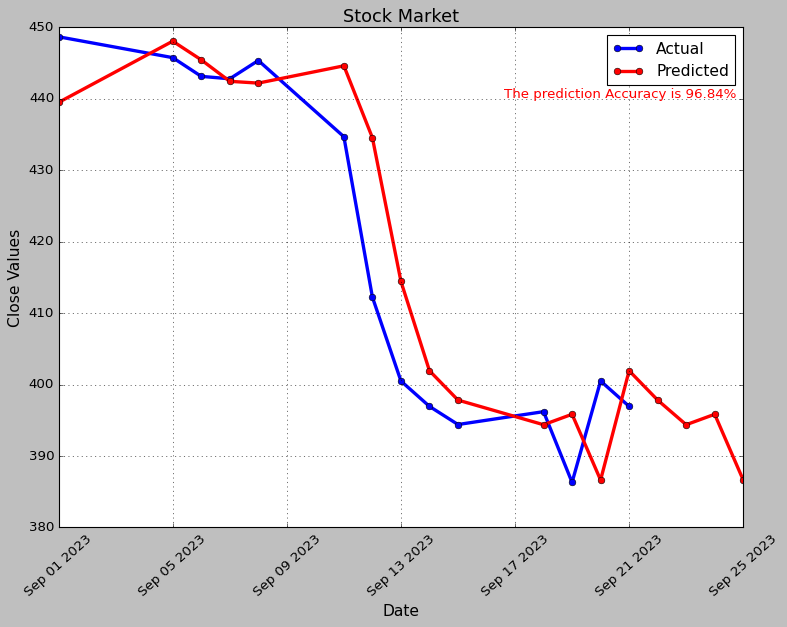

In [17]:
plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(Combined.loc["2023-09-01":f"{DATE}"].index,Combined.loc["2023-09-01":f"{DATE}","Actual"],"b-o",label="Actual",linewidth=3)
plt.plot(Combined.loc["2023-09-01":].index,Combined.loc["2023-09-01":,"Predicted"],"r-o",label="Predicted",linewidth=3)
plt.legend(loc="upper right",fontsize=14)
plt.xticks(rotation=42,)
Acc=r2_score(Combined["Actual"],Combined["Predicted"])
# Annotating a point
plt.grid()
plt.annotate(f"The prediction Accuracy is {round(Acc*100,2)}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.65, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)


plt.tight_layout()
